# Experiment 3
In this experiment, the adversarial learning technique is dropped altogether, a single Graph-based auto-encoder is used.

In [1]:
!ls ../../Projects/data/

 MNIST			       SWaT_Dataset_Normal_v1.xlsx
 SWaT_Dataset_Attack_v0.csv    WADI_14days_new.csv
 SWaT_Dataset_Attack_v0.xlsx  'WADI.A1_9 Oct 2017'
 SWaT_Dataset_Normal_v0.csv   'WADI.A2_19 Nov 2019'
 SWaT_Dataset_Normal_v0.xlsx   WADI_attackdataLABLE.csv
 SWaT_Dataset_Normal_v1.csv


In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.optim import Adam
import time
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import confusion_matrix, f1_score, roc_curve, roc_auc_score, precision_score, recall_score

### Dataset:

In [6]:
df = pd.read_csv('../../Projects/data/SWaT_Dataset_Normal_v1.csv')
df = df.drop(columns=[' Timestamp', 'Normal/Attack'])
df = df.astype('float64')

In [3]:
# grouping_array = np.arange(len(df)) // 5
# df = df.groupby(grouping_array).median()

In [7]:
mm = MinMaxScaler()

In [8]:
Normalized = pd.DataFrame(mm.fit_transform(df))
train_set = Normalized[: int(0.8 * Normalized.shape[0])]
validation_set = Normalized[int(0.8 * Normalized.shape[0]):]

/home/ahmad/anaconda3/envs/art/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/ahmad/anaconda3/envs/art/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/ahmad/anaconda3/envs/art/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/ahmad/anaconda3/envs/art/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a fu

In [9]:
class SWat_dataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame, target: pd.DataFrame,  window_size):
        self.data = dataframe
        self.window_size = window_size

    def __len__(self):
        return len(self.data) - self.window_size

    def __getitem__(self, idx):
        window = self.data[idx: idx + self.window_size]
        features = torch.tensor(window.iloc[:,:].values).float().to(device)
        return features

### Dataloader:

In [10]:
window_size = 200
input_size = window_size * 51
latent_space = 10 * window_size
epochs = 50

In [11]:
train_dataset = SWat_dataset(train_set, train_set, window_size)
validation_dataset = SWat_dataset(validation_set, validation_set, window_size)

batch_size = 4096
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

### Model:

In [12]:
class GCNLayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        
        self.dense = nn.Linear(in_dim, out_dim)

    def forward(self, adj, X):
        adj = adj + torch.eye(adj.size(0)).to(adj.device)
        h = self.dense(X)
        norm = adj.sum(1)**(-1/2)
        h = norm[None, :] * adj * norm[:, None] @ h
        return h
    
    
# A = ReLu(W)    
class Graph_ReLu_W(nn.Module):
    def __init__(self, num_nodes, k, device):
        super(Graph_ReLu_W, self).__init__()
        self.num_nodes = num_nodes
        self.k = k
        
        self.A = nn.Parameter(torch.randn(num_nodes, num_nodes).to(device), requires_grad=True).to(device)

    def forward(self, idx):
        
        adj = F.relu(self.A)
        
        if self.k:
            mask = torch.zeros(idx.size(0), idx.size(0)).to(self.device)
            mask.fill_(float('0'))
            s1,t1 = (adj + torch.rand_like(adj)*0.01).topk(self.k,1)
            mask.scatter_(1,t1,s1.fill_(1))
            adj = adj*mask
            
        return adj

# A for Directed graphs:
class Graph_Directed_A(nn.Module):
      
    def __init__(self, num_nodes, window_size, alpha, k, device):
        super(Graph_Directed_A, self).__init__()
        
        self.alpha = alpha
        self.k = k
        self.device = device
        
        self.e1 = nn.Embedding(num_nodes, window_size)
        self.e2 = nn.Embedding(num_nodes, window_size)
        self.l1 = nn.Linear(window_size,window_size)
        self.l2 = nn.Linear(window_size,window_size)
        
    def forward(self, idx):
        
        m1 = torch.tanh(self.alpha*self.l1(self.e1(idx)))
        m2 = torch.tanh(self.alpha*self.l2(self.e2(idx)))
        adj = F.relu(torch.tanh(self.alpha*torch.mm(m1, m2.transpose(1,0))))
        
        if self.k:
            mask = torch.zeros(idx.size(0), idx.size(0)).to(self.device)
            mask.fill_(float('0'))
            s1,t1 = (adj + torch.rand_like(adj)*0.01).topk(self.k,1)
            mask.scatter_(1,t1,s1.fill_(1))
            adj = adj*mask
        
        return adj

In [13]:
class GCNEncoder(nn.Module):
    def __init__(self, num_nodes, window_size, hidden_nodes, k, device):
        super(GCNEncoder, self).__init__()
        self.num_nodes = num_nodes
        self.num_features = window_size
        self.num_classes = hidden_nodes
        self.idx = torch.arange(num_nodes).to(device)
        self.k = k
        self.device = device
        
        self.gcn1 = GCNLayer(window_size, window_size // 2)
        self.bnorm1 = nn.BatchNorm1d(num_nodes)
        self.fc1 = nn.Linear(window_size // 2, window_size // 4)
        self.bnorm2 = nn.BatchNorm1d(num_nodes)
        self.fc2 = nn.Linear(window_size // 4, hidden_nodes)
        
        self.A = Graph_ReLu_W(num_nodes, k, device)
        
    def forward(self, X):
        adj = self.A(self.idx)
        h = self.gcn1(adj, X)
        h = F.relu(h)
        h = self.bnorm1(h)
        h = self.fc1(h)
        h = F.relu(h)
        h = self.bnorm1(h)
        h = self.fc2(h)
        return h
    
class GCNautoencoder(nn.Module):
    def __init__(self, num_nodes, window_size, hidden_nodes, encoder, k, device):
        super(GCNautoencoder, self).__init__()
        self.num_nodes = num_nodes
        self.num_features = window_size
        self.encoder = encoder
        self.idx = torch.arange(num_nodes).to(device)
        self.num_classes = hidden_nodes
        self.k = k
        self.device = device

        self.fc1 = nn.Linear(hidden_nodes, window_size // 4)
        self.fc2 = nn.Linear(window_size // 4, window_size // 2)
        self.gcn1 = GCNLayer(window_size // 2, window_size)
        self.bnorm1 = nn.BatchNorm1d(num_nodes)
        self.bnorm2 = nn.BatchNorm1d(num_nodes)
        
        self.A = Graph_ReLu_W(num_nodes, k, device)
        
    def forward(self, X):
        h = self.encoder(X)
        h = self.fc1(h)
        h = F.relu(h)
        h = self.fc2(h)
        h = F.relu(h)
        adj = self.A(self.idx)
        h = self.gcn1(adj, h)
        h = F.relu(h)
        return h

In [14]:
num_nodes = 51 # number of nodes
ngnn = 1 # number of graph structure learning layers
gsllayer = 'directed' # type of graph structure learning layer ('relu', 'directed', 'unidirected', 'undirected')
hidden_nodes = 25 # feature size in GCN layers
alpha = 0.1 # hyperparameter for weights of edges
k = None # max number of edges for each node
out_channels = 2 # number of process states

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [16]:
shared_encoder = GCNEncoder(num_nodes, window_size, hidden_nodes, k, device)
AE1 = GCNautoencoder(num_nodes, window_size, hidden_nodes, shared_encoder, k, device)

In [17]:
shared_encoder.to(device)
AE1.to(device)

GCNautoencoder(
  (encoder): GCNEncoder(
    (gcn1): GCNLayer(
      (dense): Linear(in_features=200, out_features=100, bias=True)
    )
    (bnorm1): BatchNorm1d(51, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc1): Linear(in_features=100, out_features=50, bias=True)
    (bnorm2): BatchNorm1d(51, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc2): Linear(in_features=50, out_features=25, bias=True)
    (A): Graph_ReLu_W()
  )
  (fc1): Linear(in_features=25, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=100, bias=True)
  (gcn1): GCNLayer(
    (dense): Linear(in_features=100, out_features=200, bias=True)
  )
  (bnorm1): BatchNorm1d(51, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bnorm2): BatchNorm1d(51, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (A): Graph_ReLu_W()
)

In [18]:
optimizer1 = torch.optim.Adam(AE1.parameters())

In [19]:
from torch.utils.tensorboard import SummaryWriter

In [24]:
writer = SummaryWriter('runs/GAE_' + f'{epochs}_epochs' + 'only autoencoder')
AE1_val_history = []
for i in range(epochs):
    running_loss_AE1 = []
    val_loss_AE1 = []
    for index_b, features in enumerate(train_loader):
        features = torch.transpose(features, 1, 2)
        
        w1 = AE1(features)
        lossAE1 = (1 / (i + 1)) * torch.mean((features - w1) ** 2)
        
        running_loss_AE1.append(lossAE1)
        lossAE1.backward()
        optimizer1.step()
        optimizer1.zero_grad()
    
    for index_b, features in enumerate(validation_loader):
        with torch.no_grad():
            features = torch.transpose(features, 1, 2)
        
            w1 = AE1(features)
            lossAE1 = (1 / (i + 1)) * torch.mean((features - w1) ** 2)
            val_loss_AE1.append(lossAE1)
    AE1_val_history.append(torch.stack(val_loss_AE1).mean().item())
    writer.add_scalar('Autoendoer_1_train_loss epoch', torch.stack(running_loss_AE1).mean().item(), i + 1)
    writer.add_scalar('Autoendoer_1_train_loss epoch', AE1_val_history[-1], i + 1)
    print(f'Epoch: {i} ---> Val loss: AE1 {AE1_val_history[-1]:.4f}')
    print(f'Train loss: AE1 {torch.stack(running_loss_AE1).mean().item():.4f}')

Epoch: 0 ---> Val loss: AE1 0.0503
Train loss: AE1 0.0598
Epoch: 1 ---> Val loss: AE1 0.0240
Train loss: AE1 0.0271
Epoch: 2 ---> Val loss: AE1 0.0158
Train loss: AE1 0.0173
Epoch: 3 ---> Val loss: AE1 0.0116
Train loss: AE1 0.0125
Epoch: 4 ---> Val loss: AE1 0.0094
Train loss: AE1 0.0098
Epoch: 5 ---> Val loss: AE1 0.0077
Train loss: AE1 0.0080
Epoch: 6 ---> Val loss: AE1 0.0064
Train loss: AE1 0.0067
Epoch: 7 ---> Val loss: AE1 0.0054
Train loss: AE1 0.0058
Epoch: 8 ---> Val loss: AE1 0.0049
Train loss: AE1 0.0050
Epoch: 9 ---> Val loss: AE1 0.0044
Train loss: AE1 0.0045
Epoch: 10 ---> Val loss: AE1 0.0041
Train loss: AE1 0.0040
Epoch: 11 ---> Val loss: AE1 0.0036
Train loss: AE1 0.0036
Epoch: 12 ---> Val loss: AE1 0.0032
Train loss: AE1 0.0033
Epoch: 13 ---> Val loss: AE1 0.0032
Train loss: AE1 0.0031
Epoch: 14 ---> Val loss: AE1 0.0029
Train loss: AE1 0.0028
Epoch: 15 ---> Val loss: AE1 0.0026
Train loss: AE1 0.0027
Epoch: 16 ---> Val loss: AE1 0.0024
Train loss: AE1 0.0025
Epoch: 

KeyboardInterrupt: 

# Testing

In [25]:
df2 = pd.read_csv('../../Projects/data/SWaT_Dataset_Attack_v0.csv')
labels = df2['Normal/Attack']
df2 = df2.drop(columns=[' Timestamp', 'Normal/Attack'])
df2 = df2.astype('float64')
df2.columns = df.columns

In [26]:
df2.shape

(449919, 51)

In [27]:
test_normalized = pd.DataFrame(mm.transform(df2))

/home/ahmad/anaconda3/envs/art/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/ahmad/anaconda3/envs/art/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/ahmad/anaconda3/envs/art/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [28]:
test_dataset = SWat_dataset(test_normalized, test_normalized, window_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [29]:
def testing(test_loader, alpha=.5, beta=.5):
    results=[]
    with torch.no_grad():
        for batch in test_loader:
            batch = torch.transpose(batch, 1, 2)
            w1=AE1(batch)
            results.append(torch.mean(torch.mean((batch-w1)**2, axis=1), axis=1))
    return results

In [30]:
labels = labels.values
labels = [0 if (lab == 'Normal') else 1 for lab in labels]

In [31]:
windows_labels=[]
for i in range(len(labels)-window_size):
    windows_labels.append(list(np.int32(labels[i:i+window_size])))

In [47]:
len(windows_labels)

449719

In [32]:
y_test = [1.0 if (np.sum(window) > 0) else 0 for window in windows_labels]

In [33]:
results=testing(test_loader, alpha=0.3, beta=0.7)

In [34]:
y_pred=np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(),
                              results[-1].flatten().detach().cpu().numpy()])

In [51]:
len(y_pred)

449719

In [35]:
def ROC(y_test,y_pred):
    fpr,tpr,tr=roc_curve(y_test,y_pred)
    auc=roc_auc_score(y_test,y_pred)
    idx=np.argwhere(np.diff(np.sign(tpr-(1-fpr)))).flatten()

    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.plot(fpr,tpr,label="AUC="+str(auc))
    plt.plot(fpr,1-fpr,'r:')
    plt.plot(fpr[idx],tpr[idx], 'ro')
    plt.legend(loc=4)
    plt.grid()
    plt.show()
    return tr[idx]

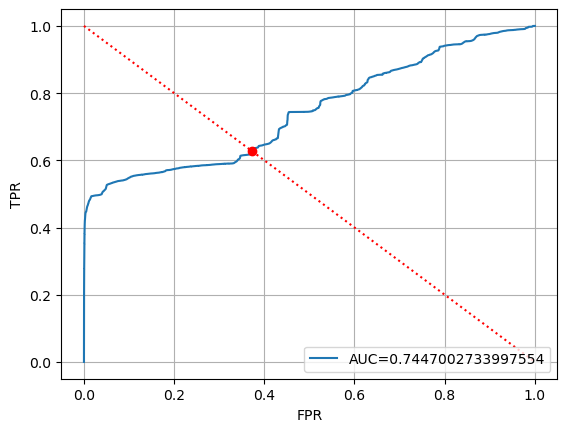

array([0.38088202], dtype=float32)

In [36]:
threshold = ROC(y_test,y_pred)
threshold

In [45]:
x_vals = 0.4 + np.linspace(0, 0.3, 50)
plt.plot(x_vals, f_history)
plt.xlabel('Threshold')
plt.ylabel('F1 score')

max_y = max(f_history)
max_x = np.argmax(f_history)
plt.axhline(y=max_y, color='r', linestyle='--', label='Max Y')
plt.text(0.6, max_y + 0.05, f'Max F1= {max_y: .4f}', color='r')
plt.ylim(0, 1)
plt.grid(True)

plt.savefig('my_plot.png')

plt.show()

NameError: name 'f_history' is not defined

best: 0.48775510204081635 F1: 0.6177614271190348


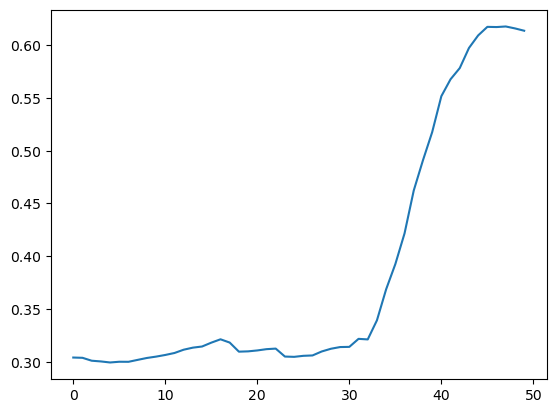

In [37]:
ff = 0
f_history = []
initial_y = 0.2
best = -1
for inc in np.linspace(0, 0.3, 50):
    y_pred_int = [1 if (yy > initial_y + inc) else 0 for yy in y_pred]
    conf_matrix = confusion_matrix(y_test, y_pred_int)
    TP = conf_matrix[1, 1]
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    F1 = f1_score(y_test, y_pred_int)
    f_history.append(F1)

    precision = precision_score(y_test, y_pred_int)
    recall = recall_score(y_test, y_pred_int)
    if F1 > ff:
        ff = F1
        best = inc
print(f'best: {best + initial_y} F1: {ff}')
plt.plot(f_history)

In [34]:
TN

149164

In [33]:
y_pred_int = [1 if (yy > 0.46938775510204084) else 0 for yy in y_pred]
conf_matrix = confusion_matrix(y_test, y_pred_int)
TP = conf_matrix[1, 1]
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]
F1 = f1_score(y_test, y_pred_int)

precision = precision_score(y_test, y_pred_int)
recall = recall_score(y_test, y_pred_int)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", F1)
print(f'TP: {TP}\nTN: {TN}\nFP: {FP}\nFN: {FN}')

Precision: 0.6346748574674437
Recall: 0.49212097484584516
F1 Score: 0.5543804842192309
TP: 30168
TN: 371052
FP: 17365
FN: 31134
